In [1]:
from collections import OrderedDict
import os

import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, accuracy_score
#import shap
#!pip install shap
import shap
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder




import dice_ml
from dice_ml.utils import helpers

from tscv import GapRollForward

/home/guilherme/miniconda3/envs/causal/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/guilherme/miniconda3/envs/causal/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/guilherme/miniconda3/envs/causal/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
df = pd.read_parquet('../data/df_final_label.parquet').sort_values(by=['data'])
df = df[df.data > '2019-01-01']
df

,id_votacao,id_parlamentar,id_parlamentar_parlametria,partido,voto,casa_x,id_proposicao,data,obj_votacao,casa_y,...,dis_disciplina,peso_investimento_partidario,peso_numero_de_mandatos,peso_indice_comissoes,peso_indice_liderancas,peso_indice_cargo_mesa,peso_indice_peso_politico,doacoes_id_parlamentar,doacoes_main_donation,doacoes_donation_value
224037,2179189-45,204571,1204571,PDT,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.000000,1.0,0.022727,0.000,0.0,0.037879,204571.0,"ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS ...",22500.000000
70819,2179189-45,204517,1204517,PMN,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.000000,1.0,0.045455,0.000,0.0,0.042424,204517.0,"ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS ...",13250.000000
224614,2179189-45,74273,174273,PSB,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.159804,5.0,0.022727,0.000,0.0,0.203173,74273.0,"ARTES, CULTURA, ESPORTE E RECREAÇÃO",4410.000000
156266,2179189-45,204352,1204352,PSB,0,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.664452,4.0,0.386364,0.250,0.0,0.393496,204352.0,"ATIVIDADES JURÍDICAS, DE CONTABILIDADE E DE AU...",3000.000000
156857,2179189-45,204531,1204531,PP,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.092610,1.0,0.204545,0.250,0.0,0.142765,204531.0,"ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS ...",8333.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148877,2272137-269,178835,1178835,PDT,0,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,0.322327,3.0,0.022727,0.250,0.0,0.219011,178835.0,"ATIVIDADES JURÍDICAS, DE CONTABILIDADE E DE AU...",270187.500000
69095,2272137-269,198197,1198197,AVANTE,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
248742,2272137-269,141553,1141553,PSDB,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,0.523810,0.080061,6.0,0.022727,0.000,0.0,0.220558,141553.0,ATIVIDADES IMOBILIÁRIAS,129694.444444
86439,2272137-269,160531,1160531,REPUBLICANOS,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,0.629602,3.0,0.022727,0.375,0.0,0.305466,NaN,None,NaN


In [3]:
themes = ["tema1","tema2"]
keyw = [feature for feature in df.columns if feature.startswith('keyw_')]
acoes = [feature for feature in df.columns if feature.startswith('acoes_')]
at_twitter = [feature for feature in df.columns if feature.startswith('atividade_twitter')]
autorias = [feature for feature in df.columns if feature.startswith('aut_')]
disc = [feature for feature in df.columns if feature.startswith('dis_')]
peso = [feature for feature in df.columns if feature.startswith('peso_')]
doacoes = [feature for feature in df.columns if feature.startswith('doacoes_')]
partido = ['partido']
features =  themes + keyw + acoes + at_twitter + autorias + disc + peso + doacoes + partido

In [4]:
features = ['partido', 'tema2', 'tema1', 'dis_num_seguiu', 'doacoes_donation_value', 'keyw_alteracao', 'dis_votos_validos', 'keyw_criacao', 'peso_indice_comissoes', 'keyw_concessao', 'keyw_inclusao', 'keyw_obrigatoriedade', 'keyw_lei federal', 'keyw_municipio', 'keyw_utilizacao', 'dis_disciplina', 'keyw_aprovacao', 'peso_numero_de_mandatos', 'peso_indice_liderancas', 'acoes_reforma-tributaria', 'atividade_twitter_transparencia-e-integridade', 'keyw_None', 'acoes_reforma-administrativa', 'keyw_proibicao', 'keyw_autorizacao', 'keyw_prazo']

In [5]:
df['acoes_direitos-humanos'].value_counts()

0.0     288380
1.0       9803
2.0       2626
3.0       1581
4.0        647
5.0        127
7.0        125
9.0         78
8.0         54
6.0         30
15.0        20
10.0        15
21.0        13
14.0         6
Name: acoes_direitos-humanos, dtype: int64

In [6]:
# themes = [feature for feature in df.columns if feature.startswith('tema_')]
# #date = ['ano','mes']
# keyw = [feature for feature in df.columns if feature.startswith('keyw_')]
# acoes = [feature for feature in df.columns if feature.startswith('acoes_')]
# at_twitter = [feature for feature in df.columns if feature.startswith('atividade_twitter')]
# autorias = [feature for feature in df.columns if feature.startswith('aut_')]
# disc = [feature for feature in df.columns if feature.startswith('dis_')]
# peso = [feature for feature in df.columns if feature.startswith('peso_')]
# doacoes = [feature for feature in df.columns if feature.startswith('doacoes_')]
# # frentes = [feature for feature in df.columns if feature.startswith('front')]
# # inv = [feature for feature in df.columns if feature.startswith('investiment')]
# partido = [feature for feature in df.columns if feature.startswith('partido_')]
# features =  themes + keyw + acoes + at_twitter + autorias + disc + peso + doacoes + partido

In [7]:
# features = ['doacoes_OUTRAS ATIVIDADES DE SERVIÇOS_proporcao_doacao', 'doacoes_COMÉRCIO VAREJISTA_proporcao_doacao', 'doacoes_ATIVIDADES JURÍDICAS, DE CONTABILIDADE E DE AUDITORIA_total_recebido_geral', 'peso_numero_de_mandatos', 'peso_indice_comissoes', 'keyw_criterio', 'tema_Política, Partidos e Eleições', 'partido_PT', 'partido_PSB', 'partido_PSOL', 'doacoes_CONSTRUÇÃO_total_por_atividade', 'keyw_pagamento', 'doacoes_VIGILÂNCIA E LOCAÇÃO DE MÃO-DE-OBRA TERCEIRIZADA_total_recebido_geral', 'partido_REPUBLICANOS', 'doacoes_INDÚSTRIA METALÚRGICA_total_recebido_geral', 'keyw_fiscalizacao', 'keyw_inclusao', 'keyw_crime', 'partido_PCdoB', 'tema_Saúde', 'tema_Arte, Cultura e Religião']
target = ['voto']

In [8]:
# df[features+target].dropna().drop(columns=['keyw_None']).sample(100).to_csv('df_input_grafo.csv',index=False)

In [9]:
categorical_features=["tema1","tema2","partido","doacoes_main_donation"]
encoder = LabelEncoder()
original = df[categorical_features]
mask = df[categorical_features].isnull()
df[categorical_features] = df[categorical_features].fillna('NaN')
df[categorical_features] = df[categorical_features].apply(encoder.fit_transform)
df[categorical_features].where(~mask, original)
df[categorical_features].astype('category')
df

,id_votacao,id_parlamentar,id_parlamentar_parlametria,partido,voto,casa_x,id_proposicao,data,obj_votacao,casa_y,...,dis_disciplina,peso_investimento_partidario,peso_numero_de_mandatos,peso_indice_comissoes,peso_indice_liderancas,peso_indice_cargo_mesa,peso_indice_peso_politico,doacoes_id_parlamentar,doacoes_main_donation,doacoes_donation_value
224037,2179189-45,204571,1204571,9,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.000000,1.0,0.022727,0.000,0.0,0.037879,204571.0,5,22500.000000
70819,2179189-45,204517,1204517,12,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.000000,1.0,0.045455,0.000,0.0,0.042424,204517.0,5,13250.000000
224614,2179189-45,74273,174273,21,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.159804,5.0,0.022727,0.000,0.0,0.203173,74273.0,4,4410.000000
156266,2179189-45,204352,1204352,21,0,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.664452,4.0,0.386364,0.250,0.0,0.393496,204352.0,7,3000.000000
156857,2179189-45,204531,1204531,14,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.092610,1.0,0.204545,0.250,0.0,0.142765,204531.0,5,8333.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148877,2272137-269,178835,1178835,9,0,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,0.322327,3.0,0.022727,0.250,0.0,0.219011,178835.0,7,270187.500000
69095,2272137-269,198197,1198197,0,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN
248742,2272137-269,141553,1141553,24,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,0.523810,0.080061,6.0,0.022727,0.000,0.0,0.220558,141553.0,6,129694.444444
86439,2272137-269,160531,1160531,32,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,0.629602,3.0,0.022727,0.375,0.0,0.305466,NaN,21,NaN


In [10]:
DEFAULT_LGB_PARAMS = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 150,
    "verbose": -1,
    "min_data_in_leaf": 5,
    "boost_from_average": True,
    "random_state": 1
    # "categorical_feature":"name:tema1,tema2,partido,doacoes_main_donation"
}

LABEL_COLUMN_NAME = 'label'
N_FOLDS = 5
N_TIMES_CV = 50

def _robust_evaluation(X, y):
    """N_TIMES_CV times 5-fold cross validation with lgb model
    
    Arguments:
        estimator {[type]} -- [description]
        X {[type]} -- [description]
        y {[type]} -- [description]
    """
    aucs = []
    for seed in range(N_TIMES_CV):
        eval_hist = lgb.cv(DEFAULT_LGB_PARAMS, lgb.Dataset(X, label=y), nfold=N_FOLDS, seed=seed)
        aucs.append(np.mean(eval_hist['auc-mean']))

    score = np.mean(aucs) 

    return score, aucs

def eval_features(df, features, target, random_state):
    """
    5-fold cross validation with LGBMClassifier
    Used to collect results for SHAP analysis
    """
    stats = OrderedDict()
    
    X = df[features].values
    y = df[target].values.ravel()

    a = [] #array to store AUCs values for each fold
    b = [] #array to store PPVs values for each fold
    # cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)
    cv = GapRollForward(min_train_size=int(300000/5), gap_size=int(300000/10), max_test_size=int(300000/5))
    max_auc = 0
    iter_max_auc = 0
    for i, (train, val) in enumerate(cv.split(X, y)):
        classifier = lgb.LGBMClassifier(**DEFAULT_LGB_PARAMS)
        classifier = classifier.fit(X[train], y[train])
        
        probas_ = classifier.predict_proba(X[val])
        auc = roc_auc_score(y[val], probas_[:, 1])
        pred_test = classifier.predict(X[val]) #making predictions for test data
        pred_train = classifier.predict(X[train]) #making predictions for train data
        ppv = precision_score(y[val], pred_test) #PPV is also the precision of the positive class
        a.append(auc)
        b.append(ppv)
        
        if auc > max_auc:
            max_auc = auc
            iter_max_auc = i
        
        
        stats[i] = {}
        stats[i]['model'] = classifier
        stats[i]['auc'] = auc
        stats[i]['X_train'] = X[train]
        stats[i]['y_train'] = y[train]
        stats[i]['y_pred_train'] = pred_train
        stats[i]['X_test'] = X[val]
        stats[i]['y_test'] = y[val]
        stats[i]['y_pred_test'] = pred_test
        
    stats['mean_auc'] = np.mean(a)
    stats['max_auc'] = np.max(a)
    stats['iter_max_auc'] = iter_max_auc
    stats['mean_ppv'] = np.mean(b)
    return stats, classifier


In [11]:
stats, classifier = eval_features(df,features,target,1)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


In [12]:
stats

OrderedDict([(0,
              {'model': LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
                              metric='auc', min_data_in_leaf=5, num_leaves=150,
                              objective='binary', random_state=1, verbose=-1),
               'auc': 0.6902950346300846,
               'X_train': array([[ 9., 19.,  7., ...,  0.,  0.,  0.],
                      [12., 19.,  7., ...,  0.,  0.,  0.],
                      [21., 19.,  7., ...,  0.,  0.,  0.],
                      ...,
                      [ 3.,  4.,  1., ...,  0.,  0.,  0.],
                      [27.,  4.,  1., ...,  0.,  0.,  0.],
                      [25.,  4.,  1., ...,  0.,  0.,  0.]]),
               'y_train': array([1, 1, 1, ..., 1, 0, 1]),
               'y_pred_train': array([1, 1, 0, ..., 1, 0, 1]),
               'X_test': array([[23.,  0.,  7., ...,  0.,  1.,  0.],
                      [ 1.,  0.,  7., ...,  0.,  1.,  0.],
                      [ 4.,  0.,  7., ...,

In [13]:
# df[features+target].to_parquet('df_input.parquet',index=False)

In [14]:
# collect data
selected_iter = stats['iter_max_auc']
X = stats[selected_iter]['X_test']
y = stats[selected_iter]['y_test']
y_pred = stats[selected_iter]['y_pred_test']

baseline = accuracy_score(y, np.zeros(len(y)))
acc = accuracy_score(y,y_pred)

# shap explain
model = stats[selected_iter]['model']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# find misclassfied and correctly classified examples
y_pred = (shap_values[1].sum(1) + explainer.expected_value[1]) > 0
misclassified = y_pred != y
correct_clas = y_pred == y
# find TP, TN, FP and FN examples
tps = [
    True if y_pred[i] == True and y[i] == True else False for i in range(len(y_pred))
]
tns = [
    True if y_pred[i] == False and y[i] == False else False for i in range(len(y_pred))
]
fps = [
    True if y_pred[i] == True and y[i] == False else False for i in range(len(y_pred))
]
fns = [
    True if y_pred[i] == False and y[i] == True else False for i in range(len(y_pred))
]

# feature order
feature_order = list(range(len(features)))
print(f'Mean AUC: {stats["mean_auc"]:.3f}')
print(f'Current fold AUC: {stats[selected_iter]["auc"]:.3f}')
#print(f'Baseline accuracy: {baseline:.3f}')
print(f'Model accuracy: {acc:.3f}')
print('Label distribution on fold:')
print(pd.Series(y).value_counts())
print(f'Number of TPS: {np.array(tps).sum()}')
print(f'Number of TNS: {np.array(tns).sum()}')
print(f'Number of FPS: {np.array(fps).sum()}')
print(f'Number of FNS: {np.array(fns).sum()}')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Mean AUC: 0.766
Current fold AUC: 0.873
Model accuracy: 0.878
Label distribution on fold:
1    25169
0     8336
dtype: int64
Number of TPS: 24308
Number of TNS: 5097
Number of FPS: 3239
Number of FNS: 861


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


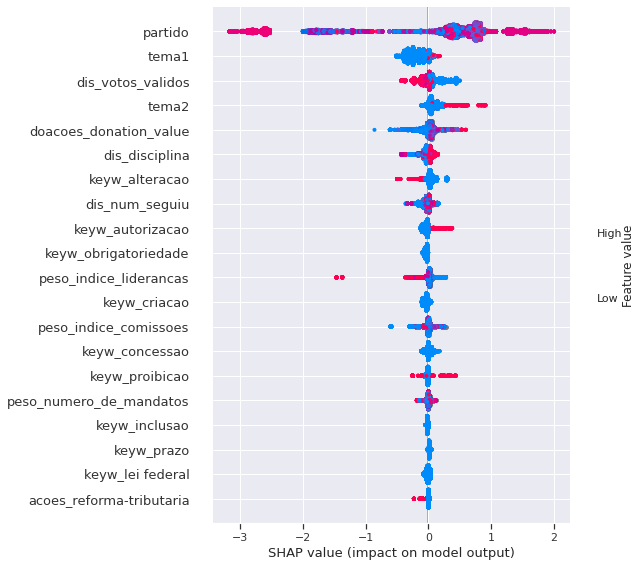

In [15]:
# summary plot (shap values 2-D)
shap.summary_plot(
    shap_values[1],
    X,
    feature_names=features)